In [1]:
!pip install dalex --quiet
!pip install shap --quiet
!pip install lime --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip install numpy --quiet
!pip install xgboost --quiet # good boost libs: XGBoost, LightGBM, CatBoost

# Understand the standard tools for model explainability

## Background


> Model explainability is a major issue for certain sectors such as insurance or banking in the validation and production of developed models. In certain situations, you will not only have to perform well but also be able to justify the decisions made by your model and explain the results. 
>
> Let's take a concrete case from everyday life: the purchase of a property. Hélène wants to become the happy owner of an apartment in Paris, so she applies for a loan from her bank. A Data Scientist has recently developed, in collaboration with a Data Engineer, an application available to bank agents that is able to predict whether or not it is profitable to grant the loan, based on a few characteristics such as the person's gender. Hélène is refused a loan and surprised by the decision, she asks her bank for an explanation, which she is obliged to provide by detailing the strengths and weaknesses of Hélène's file. The bank must therefore be able to explain to Hélène which characteristics weighed positively and especially negatively in the rejection of her loan. This requires the data scientist to provide at least some figures or a graphical interface explaining the local situation of Helen. We will show that it is possible to use simple tools to answer this question. 
> 
> Behind the question of explaining the model's decision to Hélène are several issues, including :
>* Fairness: Ensuring that predictions are unbiased and do not implicitly or explicitly discriminate against underrepresented groups. An interpretable model can tell you why it has decided that a certain person should not get a loan, and it becomes easier for a human to judge whether the decision is based on a learned demographic (e.g. racial) bias.
>* Privacy: Ensuring that sensitive information in the data is protected.
>* Reliability or Robustness: Ensuring that small changes in the input do not lead to large changes in the prediction.
>* Causality: Check that only causal relationships are picked up.
>* Trust: It is easier for humans to trust a system that explains its decisions compared to a black box.
> 
> Explainability aims to respond to these challenges and to bring confidence to the data scientists who model, to the businesses or to the users who use the model. It is a crucial point so that the people for whom you create the data product accept it and use it on a daily basis. 

## Model-specific or model-agnostic

> Model-specific interpretation tools are limited to specific model classes. The interpretation of regression weights in a linear model is a model-specific interpretation, since – by definition – the interpretation of intrinsically interpretable models is always model-specific. Tools that only work for the interpretation of e.g. neural networks are model-specific. Model-agnostic tools can be used on any machine learning model and are applied after the model has been trained (post hoc). These agnostic methods usually work by analyzing feature input and output pairs. By definition, these methods cannot have access to model internals such as weights or structural information.
>
> The interpretation tools specific to the models may contradict each other depending on the specific criterion studied.

## Local vs Global

> When we talk about explainability, it is possible to try to explain the decision of the model for a particular individual or the global behavior of the model. The first option can for example help us to understand the errors of the model for a restricted group of observations, the second option to detect biases. 
>
> Example realized on the **`housing.csv`** dataset.

In [1]:
import pandas as pd
import dalex as dx

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

# print the first 5 rows of the dataset
print(X.head(5))
print(y.head(5))


clf_gb = GradientBoostingRegressor(n_estimators = 250, max_depth=12, random_state=1234)
clf_rf = RandomForestRegressor(n_estimators = 250, max_depth=12, random_state=1234)

clf_gb.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)

print("GradientBoosting score on train :", clf_gb.score(X_train, y_train))
print("RandomForest score on train :", clf_rf.score(X_train, y_train))

print("GradientBoosting score on test :", clf_gb.score(X_test, y_test))
print("RandomForest score on test :", clf_rf.score(X_test, y_test))

GradientBoosting score on train : 0.9997399292269133
RandomForest score on train : 0.9182912717141076
GradientBoosting score on test : 0.823128630171869
RandomForest score on test : 0.8040242936464083


In [5]:
# print the first 5 rows of the dataset
print("X samples: \n", X.head(5))
print()
print("y labels: \n", y[:5])

X samples: 
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

y labels: 
 0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64


## Partial Dependence Plot (PDP)

> The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.
>
> The partial function $\hat{f}_{s}$ is estimated by calculating averages in the training data, also known as Monte Carlo method:
> <center> $\hat{f}_{s}(x_s)=\frac{1}{n}\sum_{i=1}^{n}\hat{f}(x_s, x_c^{(i)})$ </center>
>
> The partial function tells us for given value(s) of features S what the average marginal effect on the prediction is. In this formula, $x_c^{(i)}$ are actual feature values from the dataset for the features in which we are not interested, and n is the number of instances in the dataset. An assumption of the PDP is that the features in C are not correlated with the features in S. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.

In [6]:
housing_gb_exp = dx.Explainer(clf_gb, X_train, y_train, label = "Housing gb")

pdp_gb = housing_gb_exp.model_profile(variables = ["HouseAge", 'MedInc'])
pdp_gb.plot()

Preparation of a new explainer is initiated

  -> data              : 16512 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16512 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : Housing gb
  -> predict function  : <function yhat_default at 0x7f6db44681f0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/home/onyr/anaconda3/envs/explain/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


  -> predicted values  : min = 0.148, mean = 2.07, max = 5.02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.107, mean = -8.08e-17, max = 0.14
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


## Permutation Importance

> The permutation feature importance algorithm based on Fisher, Rudin, and Dominici (2018):
>
> Input: Trained model $\hat{f}$, feature matrix $X$, target vector $y$, error measure $L(y,\hat{f})$ :
>* Estimate the original model error $L(y,\hat{f})$.
>* For each feature $j \in (1,...,p)$ do:
>** Generate feature matrix $X_{perm}$ by permuting feature j in the data X. This breaks the association between feature j and true outcome y.
>** Estimate error $L(y,\hat{f}(X_{perm}))$ based on the predictions of the permuted data.
>** Calculate permutation feature importance as difference $FI_j = L(y,\hat{f}) - L(y,\hat{f}(X_{perm}))$
>* Sort features by descending FI.

In [7]:
housing_gb_exp = dx.Explainer(clf_gb, X_test, y_test, label = "Housing gb")

mp_gb = housing_gb_exp.model_parts(loss_function='r2')
mp_gb.plot()

Preparation of a new explainer is initiated

  -> data              : 4128 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4128 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : Housing gb
  -> predict function  : <function yhat_default at 0x7f6db44681f0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.464, mean = 2.07, max = 5.08
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.21, mean = -0.00987, max = 2.95
  -> model_info        : package sklearn

A new explainer has been created!


/home/onyr/anaconda3/envs/explain/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



#  LIME [(Ribeiro .al 2016)](https://arxiv.org/abs/1602.04938)

## Intuition
*Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation*

<p align="center">
<img src=https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png width=400>
</p>

## Algorithm steps 
The different steps computed by the algorithm are the following :

### 1. Creation of a neighbourhood around the instance : 
- Data samples are generated by applying perturbations around the instance following a normal distribution
- A weight is allocated to every sample with regard to its proximity to the instance. This is the crucial step. The instance explanations may differ a lot with regard to the kernel used to compute the weights. 2 variables are at stake here, the kernel function and the kernel width :
  - the kernel function $k$ :
  $$k(d, k_w) = exp(\frac{-d^2}{k_w})$$ 
  where $$d = \sqrt{\sum_{i}^{} (y_i - x_i)^2}$$
  - the kernel width $k_w$ :
$$k_w = 0.75*\sqrt{n_f}$$ 
with $n_f$ the number of features in the train set.

$k$ and $k_w$ are 2 parameters of our LIME function and can be customised.

An example of the impact of the kernel width on the instance explanation :

<p align="center">
<img src=https://christophm.github.io/interpretable-ml-book/images/lime-fail-1.png width=500>
</p>

### 2. Generate the samples labels 
Make black-box model predictions on the newly generated neighbourhood dataset to generate the associated labels.

### 3. Fit a linear model on the samples
A linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation

# LIME for text

LIME for text data has one major difference with LIME for tabular data : the way the samples are generated and their weights computed. Let's take again the first step of the algorithm, illustrated with a YouTube comments Spam classification model.

|| CONTENT      | CLASS |
|-----------| ----------- | ----------- |
|267| PSY is a good guy      | 0       |
|173| For Christmas Song visit my channel! ;)   | 1        |

### 1. Creation of a neighbourhoods around the instance : 

- Data samples are generated by randomly removing some words from the instance text. The neighbourhood dataset is a dataset a binary features, where the value is 1 if the corresponding word is included and 0 if it has been removed.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) |
| -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|
|0|1|1|1|1|0|1|
|1|0|0|1|1|1|1|
|1|0|1|1|1|1|1|
|0|1|1|1|0|0|1|

- A weight is allocated to every sample with regard to its proximity to the instance. With LIME for text, the weight is calculated with the same kernel than for tabular data, with a default kernel width of 25 (kernel width can be customised).

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight |
| -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|
|0|1|1|1|1|0|1|0.92|
|1|0|0|1|1|1|1|0.92|
|1|0|1|1|1|1|1|0.96|
|0|1|1|1|0|0|1|0.89|

### 2. Generate the samples labels 

- This second step is very close to the one for tabular data. The class 1 probability is calculated for every sample using the black-box model's predictions.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight | prob |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|0.17|
|0|1|1|1|1|0|1|0.92|0.17|
|1|0|0|1|1|1|1|0.92|0.99|
|1|0|1|1|1|1|1|0.96|0.99|
|0|1|1|1|0|0|1|0.89|0.17|

### 3. Fit a linear model on the samples
- This third step remains the same, a linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation.

# Now let's practice !

## Packages installation & Imports 

In [30]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

## Mount Drive (ONLY USE IF WORKING ON GOOGLE COLAB)
If working on Google Colab, you can modify the PATH to the folder on which you uploaded the data on your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/"

## Data Loading

Download the train.csv & test.csv datasets from github ([link](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv))

In [20]:
import os

PATH = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/"

df_train = pd.read_csv(os.path.join(PATH,"train.csv"), header = None)
df_test = pd.read_csv(os.path.join(PATH,"test.csv"), header = None)

## Columns name cleaning

In [21]:
# TODO : 
#   - Rename the first column as "target", the 2nd as "title", the third as "description"
print("df before renaming:", df_train.columns)
df_train.columns = ["target", "title", "description"]
print("df after renaming:", df_train.columns)

print("df before renaming:", df_test.columns)
df_test.columns = ["target", "title", "description"]
print("df after renaming:", df_test.columns)

df before renaming: Int64Index([0, 1, 2], dtype='int64')
df after renaming: Index(['target', 'title', 'description'], dtype='object')
df before renaming: Int64Index([0, 1, 2], dtype='int64')
df after renaming: Index(['target', 'title', 'description'], dtype='object')


In [22]:
#   - Lower the text
print("df before lower:")
display(df_train.head(5))

df_train["title"] = df_train["title"].str.lower()
df_train["description"] = df_train["description"].str.lower()
print("df after lower:")
display(df_train.head(5))

df before lower:


,target,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


df after lower:


,target,title,description
0,3,wall st. bears claw back into the black (reuters),"reuters - short-sellers, wall street's dwindli..."
1,3,carlyle looks toward commercial aerospace (reu...,reuters - private investment firm carlyle grou...
2,3,oil and economy cloud stocks' outlook (reuters),reuters - soaring crude prices plus worries\ab...
3,3,iraq halts oil exports from main southern pipe...,reuters - authorities have halted oil export\f...
4,3,"oil prices soar to all-time record, posing new...","afp - tearaway world oil prices, toppling reco..."


## TF-IDF Vectorizer & Logistic Regression 

In [23]:
#TF-IDF
tfidf_vc = TfidfVectorizer(
    min_df = 10, 
    max_features = 100000, 
    analyzer = "word", 
    ngram_range = (1, 2), 
    stop_words = 'english', 
    lowercase = True
)

# Logistic Regression
model = LogisticRegression(C = 0.5, solver = "sag")

# Pipeline definition
pipe = make_pipeline(tfidf_vc, model)

# Pipeline training
pipe.fit(df_train["description"], df_train.target)

# Predictions on test_set
test_pred = pipe.predict(df_test["description"])

## Evaluation

              precision    recall  f1-score   support

           1       0.93      0.90      0.92      1900
           2       0.95      0.98      0.96      1900
           3       0.88      0.87      0.88      1900
           4       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

[[1717   57   74   52]
 [  19 1858   15    8]
 [  63   21 1652  164]
 [  52   24  133 1691]]


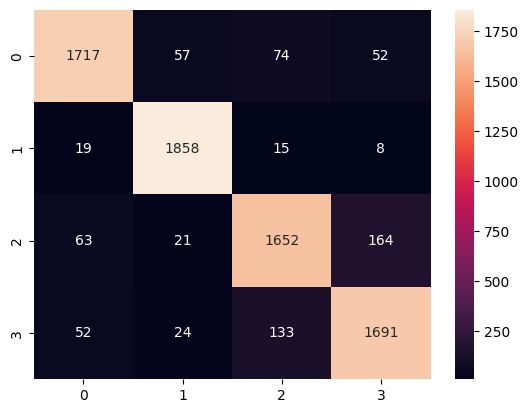

In [26]:
print(classification_report(df_test.target, test_pred))
print(confusion_matrix(df_test.target, test_pred))

import seaborn as sns

# display the confusion matrix
cm = confusion_matrix(df_test.target, test_pred)
sns.heatmap(cm, annot=True, fmt="d")

import plotly.express as px

px.imshow(cm)

## Explicability with LIME

NameError: name 'explainer' is not defined

In [34]:
# idx = ??? TO FILL
# get a random index from the test set
import numpy as np
len(df_test)
idx = np.random.randint(0, len(df_test))

class_names = ["World", "Sports", "Business", "Sci/Tech"]
explainer = LimeTextExplainer(class_names = class_names)

exp = explainer.explain_instance(
    df_test["description"][idx], 
    classifier_fn=pipe.predict_proba,
    num_features = 10, 
    top_labels=3
)

exp.show_in_notebook(text=df_test["description"][idx])

# LIME for image

LIME algorithm for images works a little differently than for tabular data and text. Indeed, perturbing individual pixels one by one will not really change the prediction because more than one pixel contribute to one class. 



## Algorithm steps 
The different steps computed by the algorithm are the following :

### 1. Creation of superpixels : 
The alorithm first requires to generate "superpixels" which are composed of contigous pixels that share properties such as texture or color distribution.This step is crucial for the generation of the LIME explanation since perturbation of superpixels is used to identify which of the image areas has been relevant for a specific class decision.

LIME uses the quickshift algorithm to produce these superpixels (more details here : https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/vedaldi08quick.pdf)

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure3-2cea505fe733a4713eeff3b90f696507.jpg width=500>
</p>


### 2. Generate perturbed instances :
Once the superpixels are defined, we can generate a new dataset of perturbed instances by turning off superpixels on the image. The interpretable representation of the image is a binary vector where 1 indicates the original super-pixel and 0 indicates a grayed out super-pixel.

### 3. Fit a linear model on the samples

We can now fit a linear model on the perturbed instance to a specific class and highlight the superpixels with positive or negative weight towards a specific class.

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure4-99d9ea184dd35876e0dbae81f6fce038.jpg width=500>
</p>


# Now let's practice !

## Packages installation & Imports 






In [35]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net

2023-01-18 15:28:16.602914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:28:16.702958: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-18 15:28:16.706740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 15:28:16.706756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

## Load pre-trained InceptionV3 model and images

In [36]:
# Load model
inception_model = InceptionV3(weights='imagenet')

2023-01-18 15:30:25.953452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-18 15:30:25.953476: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-18 15:30:25.953497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kenzael): /proc/driver/nvidia/version does not exist
2023-01-18 15:30:25.953724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


96112376/96112376 [==============================] - 3s 0us/step


### TODO : Here you can download any images and identify the way to access them on your computer / on drive

In [47]:
# Image processing
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## TODO : apply transform_img_fn on 3 images and affect the result to a list of images called "images"
import glob

img_path = "../img/"
img_path_list = glob.glob(img_path + "*")
images = transform_img_fn(img_path_list)

print(type(images))

<class 'numpy.ndarray'>


## Make some predictions

1/1 [==============================] - 0s 185ms/step


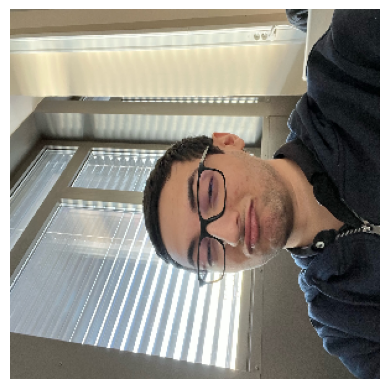

('n04070727', 'refrigerator', 0.8349236)
('n03207941', 'dishwasher', 0.045345787)
('n07753592', 'banana', 0.0073039257)
('n04265275', 'space_heater', 0.0067064934)
('n02788148', 'bannister', 0.0058320146)


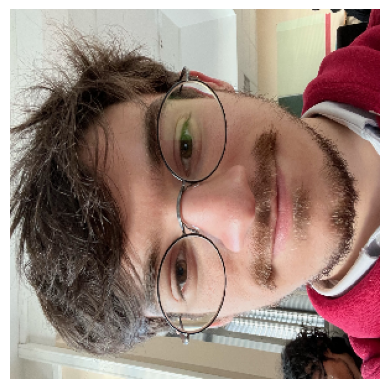

('n03692522', 'loupe', 0.9359266)
('n02791270', 'barbershop', 0.0049286927)
('n03630383', 'lab_coat', 0.0048816027)
('n03814639', 'neck_brace', 0.0025707697)
('n04209133', 'shower_cap', 0.0020896571)


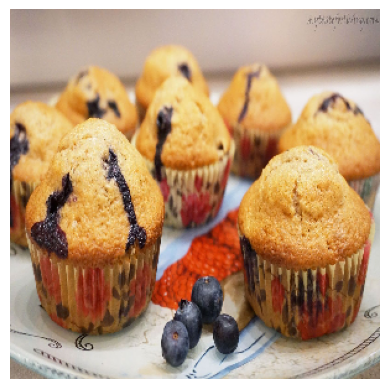

('n02776631', 'bakery', 0.19419995)
('n07836838', 'chocolate_sauce', 0.12391125)
('n07579787', 'plate', 0.06175621)
('n07684084', 'French_loaf', 0.06081512)
('n07693725', 'bagel', 0.0583374)


In [53]:
# Predictions
preds = inception_model.predict(images)

# display the image
def display_img_and_predictions(img, pred):
    plt.imshow(img / 2 + 0.5)
    plt.axis('off')
    plt.show()

    for x in pred:
        print(x)

for i in range(len(images)):
    display_img_and_predictions(images[i], decode_predictions(preds)[i])

In [44]:
# TODO: 
# With de decode_predictions function print the 5 most probable classes into a list of tuples (class, description, probability)

for x in decode_predictions(preds)[0]:
    print(x)

for x in decode_predictions(preds)[1]:
    print(x)

1/1 [==============================] - 0s 113ms/step
('n02776631', 'bakery', 0.19420059)
('n07836838', 'chocolate_sauce', 0.12391131)
('n07579787', 'plate', 0.061756562)
('n07684084', 'French_loaf', 0.060814943)
('n07693725', 'bagel', 0.058337126)


IndexError: list index out of range

## Explicability with LIME image

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 503ms/step


 10%|█         | 10/100 [00:00<00:05, 16.98it/s]

1/1 [==============================] - 0s 492ms/step


 20%|██        | 20/100 [00:01<00:04, 17.01it/s]

1/1 [==============================] - 0s 496ms/step


 30%|███       | 30/100 [00:01<00:04, 17.01it/s]

1/1 [==============================] - 0s 441ms/step


 40%|████      | 40/100 [00:02<00:03, 17.82it/s]

1/1 [==============================] - 0s 435ms/step


 50%|█████     | 50/100 [00:02<00:02, 18.30it/s]

1/1 [==============================] - 0s 437ms/step


 60%|██████    | 60/100 [00:03<00:02, 18.64it/s]

1/1 [==============================] - 0s 445ms/step


 70%|███████   | 70/100 [00:03<00:01, 18.76it/s]

1/1 [==============================] - 0s 471ms/step


 80%|████████  | 80/100 [00:04<00:01, 18.64it/s]

1/1 [==============================] - 0s 497ms/step


 90%|█████████ | 90/100 [00:04<00:00, 18.10it/s]

1/1 [==============================] - 1s 511ms/step


100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


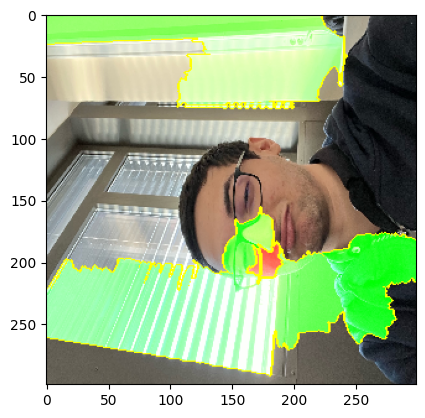

In [60]:
# TODO: play with the different parameters

# Train lime image explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    images[0].astype('double'), 
    inception_model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=100
)

# Plot boundaries
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=0, 
    num_features=10, 
    hide_rest=0
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Plotting the heatmap

<class 'list'>
<class 'tuple'>


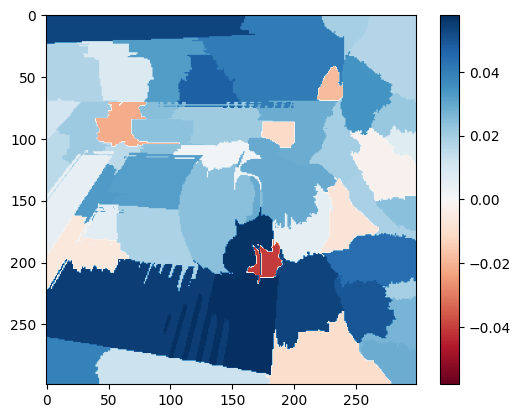

In [65]:
# TODO : Select the same class explained on the figures above and return it as a variable called "ind"
ind = explanation.top_labels[0]

# TODO : What does explanation.local_exp[ind] return ? -> list of tuples
print(type(explanation.local_exp[ind]))
print(type(explanation.local_exp[ind][0]))

# TODO : Map each explanation weight to the corresponding superpixel and return it as a dict called dict_heatmap
dict_heatmap = dict(explanation.local_exp[ind])

heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# **SH**apley **A**dditive ex**P**lanations ([Lundberg et .al 2017](https://arxiv.org/abs/1905.04610))

## From Game Theory


* In game theory, the [Shapley value](https://en.wikipedia.org/wiki/Shapley_value) (1953) is a solution concept of fairly distributing both gains and costs to several actors working in coalition.
* The Shapley value applies primarily in situations when the contributions of each actor are unequal, but they work in cooperation with each other to obtain the payoff.

You first start by identifying each player’s contribution when they play individually, when 2 play together, and when all 3 play together.
<p align="center">
<img src=https://clearcode.cc/wp-content/uploads/2016/11/ABC-wide.png?ver=1478561348 width=500>
</p>

Then, you need to consider all possible orders and calculate their marginal value – e.g. what value does each player add when player A enters the game first, followed by player B, and then player C.
Below are the 6 possible orders and the marginal value each player adds in the different combinations:
<p align="center">
<img src=https://clearcode.cc/wp-content/uploads/2016/11/ABC-updated.png?ver=1479258642 width=500>
</p>

Now that we have calculated each player’s marginal value across all 6 possible order combinations, we now need to add them up and work out the Shapley value (i.e. the average) for each player.

<ins>Example for Player A:</ins>
$ \text{Shapley}_{value} = \frac{7+7+10+3+9+10}{6} \approx 7.7$

Computing the Shapley value for each player will give the true contribution each player made to the game and assign credit fairly

## To Explainability Method

* Each value of an independent variable or a feature for a given sample is a part of a cooperative game where we assume that prediction is actually the payout.
* Shapley values correspond to the contribution of each feature towards pushing the prediction away from the expected value.

Let take an example of a local prediction of a house price and see how the different features are impacting the prediction. 
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_waterfall.png width=700>
</p>

Example of features definition: 
* LSTAT (% of lower status population)
* RM (average number of rooms per house in an area)
* NOX (nitric oxides concentration)
* RAD (index of accessibility to radial highways)
* For more information, link to [Boston dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) 


## Explanation of SHAP through visualization

### Global explainability & local explanation summary
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_global_bar.png width=470>
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_beeswarm.png width=530>
</p>

### Local explainability and correlation
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_scatter.png width=500>
</p>

## Advantages
* SHAP has a solid theoretical foundation in game theory. The prediction is fairly distributed among the feature values. We get contrastive explanations that compare the prediction with the average prediction.
* SHAP connects LIME and Shapley values.
* SHAP has a fast implementation for tree-based models.
* When computation of the many Shapley values is possible, global model interpretations can be built. The global interpretation methods include feature importance, feature dependence, interactions, clustering and summary plots.

## Drawbacks
* Slow computation if you want to compute Shapley values for many instances (except for tree-based models).
* The disadvantages of Shapley values also apply to SHAP: Shapley values can be misinterpreted.
* Since every model is trained from observational data, it is not necessarily a causal model.

For more information on SHAP values see: https://github.com/slundberg/shap

## Practical exercise

Download the dataset from Kaggle ([link](https://www.kaggle.com/paololol/league-of-legends-ranked-matches))

The objective in a game of League of Legends is to destroy the enemy base, in a 5 vs. 5 match. Using datasets with statistics of the game and the players, the goal is to predict the probability to win the game. 

In [114]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

shap.initjs()

In [115]:
# TODO : 
# - read the data from matches.csv, participants.csv, stats1.csv, stats2.csv into matches participants stats1 and stats2 DataFrame. 
# - concat stats1 and stats2 into a stats DataFrame 

DATA_DIR_PATH = "../data/lol_ranked_match_kaggle/"
matches = pd.read_csv(DATA_DIR_PATH + "matches.csv")
participants = pd.read_csv(DATA_DIR_PATH + "participants.csv")
stats1 = pd.read_csv(DATA_DIR_PATH + "stats1.csv")
stats2 = pd.read_csv(DATA_DIR_PATH + "stats2.csv")
stats = pd.concat([stats1, stats2], axis=0)

Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.


In [116]:
# TODO : Explore the DataFrames
display(matches.head())
display(participants.head())
display(stats.head())

,id,gameid,platformid,queueid,seasonid,duration,creation,version
0,10,3187427022,EUW1,420,8,1909,1495068946860,7.10.187.9675
1,11,3187425281,EUW1,420,8,1693,1495066760778,7.10.187.9675
2,12,3187269801,EUW1,420,8,1482,1495053375889,7.10.187.9675
3,13,3187252065,EUW1,420,8,1954,1495050993613,7.10.187.9675
4,14,3187201038,EUW1,420,8,2067,1495047893400,7.10.187.9675


,id,matchid,player,championid,ss1,ss2,role,position
0,9,10,1,19,4,11,NONE,JUNGLE
1,10,10,2,267,3,4,DUO_SUPPORT,BOT
2,11,10,3,119,7,4,DUO_CARRY,BOT
3,12,10,4,114,12,4,SOLO,TOP
4,13,10,5,112,4,3,SOLO,MID


,id,win,item1,item2,item3,item4,item5,item6,trinket,kills,...,neutralminionskilled,ownjunglekills,enemyjunglekills,totcctimedealt,champlvl,pinksbought,wardsbought,wardsplaced,wardskilled,firstblood
0,9,0,3748,2003,3111,3053,1419,1042,3340,6,...,69,42,27,610,13,0,0,10,0,0
1,10,0,2301,3111,3190,3107,0,0,3364,0,...,1,1,0,211,14,1,0,17,3,0
2,11,0,1055,3072,3006,3031,3046,1036,3340,7,...,3,1,2,182,14,1,0,13,5,0
3,12,0,1029,3078,3156,1001,3053,0,3340,5,...,6,6,0,106,15,0,0,3,0,0
4,13,0,3020,1058,3198,3102,1052,1026,3340,2,...,4,3,1,159,15,0,0,10,0,0


In [117]:
# TODO : merge matches participants and stats into a single DataFrame called allstats
allstats = pd.merge(pd.merge(matches, participants, on="id"), stats, on="id")
print(allstats.shape)

(158554, 70)


In [118]:
# TODO : drop games that lasted less than 10 minutes
allstats = allstats[allstats["duration"] >= 600]
print(allstats.shape)

(154321, 70)


In [119]:
# TODO : which columns are string-based categories ?
col = allstats.select_dtypes(include="object").columns
print(col)

Index(['platformid', 'version', 'role', 'position', 'wardsbought'], dtype='object')


In [120]:
# TODO : Except for wardsbought, convert string-based categories to numeric values. 
# ints : use df[col].astype('category') and get the codes of the categories
for c in col:
    if c != "wardsbought":
        allstats[c] = allstats[c].astype('category').cat.codes
    else:
        allstats[c] = allstats[c].astype('int')

In [121]:
# TODO : Reduce dataset size to accelerate training filetring matchid lower than 50000
allstats = allstats[allstats["gameid"] > 50000]

In [122]:
# TODO : Return an X DataFrame after removing the "win" column and a y Serie corresponding to the "win" colmun
X = allstats.drop(columns=["win"])
y = allstats["win"]

In [123]:
# convert all following features we want to consider as rates
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

In [124]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

display(Xt.info())

dt = xgb.DMatrix(Xt, label=yt )
dv = xgb.DMatrix(Xv, label=yv )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123456 entries, 90002 to 85528
Data columns (total 69 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   id                                       123456 non-null  int64  
 1   gameid                                   123456 non-null  int64  
 2   platformid                               123456 non-null  int8   
 3   queueid                                  123456 non-null  int64  
 4   seasonid                                 123456 non-null  int64  
 5   duration                                 123456 non-null  int64  
 6   creation                                 123456 non-null  int64  
 7   version                                  123456 non-null  int16  
 8   matchid                                  123456 non-null  int64  
 9   player                                   123456 non-null  int64  
 10  championid                   

None

In [125]:
# We want to solve a logistic regression with a logloss evaluation
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": 'logloss'
}
# TODO : with xgb.train method, code the training part for 300 iterations with early stopping rounds at 5 and a verbose eval at 25
model = xgb.train(params, dt, num_boost_round=300, evals=[(dv, "Validation")], early_stopping_rounds=5, verbose_eval=25)

In [126]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'str'>

In [ ]:
# Force plot example for a record
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

In [ ]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

In [ ]:
# Global explainability
shap.plots.bar(explainer(Xv))

In [ ]:
# Local explanation summary
shap.summary_plot(shap_values, Xv)

In [ ]:
# Dependence plot between variables (automatic)
shap.dependence_plot("Gold earned per min.", shap_values, Xv)

In [ ]:
# Dependence plot between variables (assigned)
shap.dependence_plot("Gold earned per min.", shap_values, Xv, alpha=0.2, interaction_index="Deaths per min.")

In [ ]:
# TODO : sort the features indexes by their importance in the model and return them in top_inds list


# TODO : with shap.dependence_plot(), make SHAP plots of the three most important features


In [ ]:
# Play with plot variables
shap.dependence_plot("id", shap_values, Xv, x_jitter="?", alpha="?", dot_size="?")

## Bonus Section: Chest X-Ray Images

> In recent years, convolutional neural networks have been widely used in image recognition tasks and have obtained excellent results. A team of radiologists who wish to be helped in the detection of pneumonia on chest X-ray images have called on a team of data scientists to train a convolutional neural network capable of determining whether a X-ray is that of a patient with pneumonia or not.
>
> However, before using it to be assisted on a daily basis by this model, they want to ensure its relevance. It is essential for them that the model uses the lung region to determine whether a patient has pneumonia or not.
>
> The trained model has been saved in the h5 format and is named **model.h5**. You have access to the images used to test the model in the directory named **test**.
>
> Your task will involve two aspects:
>* Determine if the model is relevant from a medical point of view.
>* If necessary, propose an approach to make the model more relevant.

In [ ]:
# load trained model

from keras.models import load_model

model = load_model("/content/gdrive/MyDrive/.../model.h5")

## Going further with Explainability

### SHAPASH ([Github](https://github.com/MAIF/shapash))

A module developped by MAIF using SHAP methodology with nice features such as a web app for exploration and ML OPS usage.

[Demo](https://shapash-demo.ossbymaif.fr/) of the dashboarding capabilities.

[Notebook](https://github.com/MAIF/shapash/blob/master/tutorial/tutorial03-Shapash-overview-model-in-production.ipynb) example for ML OPS usage

#### Strengths 
* A great tool for data scientists to investigate a model's behaviour faster ! 
* Ongoing development today to add new features 

#### Weaknesses
* It "just" a plotly layer on top of SHAP not a end-user-driven Framework for model explanations
* Decision making based on the graphs is not immediate, it only provides insights 
* Audiences need to be a bit technical to be confortable with the approach 